# AI un mensaje oculto para ti (Taller)


## Imporportar datos de entrada

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# Añadir rutas de los inputs de nuestro DRIVE
PATH_DRIVE = '/content/drive/My Drive'
PATH_DATA = f'{PATH_DRIVE}/T3chFest_taller_ai_un_mensaje_oculto/data'
PATH_IMAGES = f'{PATH_DATA}/images/JPEGImages.zip'

### Ejercicio 1

Objetivo: Cargar imagen desde un zip y visualizar distintos elementos.



In [ ]:
%pylab inline

import zipfile
# TODO: acceder al zip
archive = zipfile.ZipFile(f'{PATH_IMAGES}', 'r')

from PIL import Image
# TODO: visualizar una imagen dentro del zipfile
imgfile = archive.open('JPEGImages/2012_004330.jpg')
Image.open(imgfile)

### Ejercicio 2

Objetivo: Preparar imagen para entrenamiento del modelo. Se necesita una imagen de tamaño 64x64

In [ ]:
SIZE_IMAGE = 64
WIDTH = SIZE_IMAGE
HEIGHT = SIZE_IMAGE

def open_image_and_resize(image, width, height):
  # TODO: redimensionar imagen a tamaño 64x64
  im = Image.open(image)
  newsize = (width, height)
  image_resized = im.resize(newsize)
  return image_resized


result_imagen_resized = open_image_and_resize(imgfile, WIDTH, HEIGHT)
# Visualizar imagen redimensionada
result_imagen_resized

## Sobre el modelo y uso Pytorch

### Creación de clase Dataset en Pytorch

Declarar una clase para trabajar con Datasets

In [ ]:
# imports 
import os
import csv
import torch
import numpy as np
from contextlib import contextmanager
from torchvision import datasets, transforms

class _ImageZipDataset(torch.utils.data.Dataset):
    def __init__(self, zip_file, samples, archive, transform=None, target_transform=None):
        self.zip_file = zip_file
        self.archive = archive
        self.samples = samples
        self.transform = transform
        self.target_transform = target_transform
        print(self.archive)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        print(f"path_image: {path} y {target}")

        sample = Image.open(self.archive.open(path)).convert('RGB')

        if self.transform is not None:
            sample = self.transform(sample)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self):
        return len(self.samples)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

class ImageZipDatasetWrapper(torch.utils.data.Dataset):
    """
    A dataset where images are stored in a zip file:
    <filename>.zip@/<img_1>.JPEG
    <filename>.zip@/<img_2>.JPEG
    <filename>.zip@/<img_3>.JPEG
    ...
    And the class assignments are stored in a TSV file:
    .../<filename>.zip@<img_1>.JPEG    <class_a>
    .../<filename>.zip@<img_2>.JPEG    <class_b>
    .../<filename>.zip@<img_3>.JPEG    <class_c>
    Args:
        zip_path (string): path to zip file
        transform (callable, optional): transforms to apply to each image
        target_transform (callable, optional): transforms to apply to each target
    """

    def __init__(self, zip_path, transform=None, target_transform=None, n_samples=14000):
        if not os.path.exists(zip_path):
            raise RuntimeError('%s does not exist' % zip_path)

        self.zip_path = zip_path
        self.transform = transform
        self.target_transform = target_transform

        self.archive = zipfile.ZipFile(f'{zip_path}', 'r')
        self.samples = []
        for image_path in archive.namelist()[1:]:
          self.samples.append(archive.open(image_path))
        if transform:
          convert_tensor = transforms.ToTensor()
          self.data = [np.array(open_image_and_resize(x, WIDTH, HEIGHT)).astype(np.uint8) for x in self.samples[0:n_samples]]
          self.data = np.array(self.data)
        print(self.archive)

    @contextmanager
    def dataset(self):
        with ZipFile(self.zip_path, 'r') as zip_file:
            res = _ImageZipDataset(
                zip_file=zip_file,
                archive=self.archive,
                samples=self.samples,
                transform=self.transform,
                target_transform=self.target_transform,
            )
            yield res

    def __len__(self):
        return len(self.samples)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Zip Location: {}\n'.format(self.zip_path)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

Definir una transformación para normalizar los datos y crear un objeto de tipo dataset

In [ ]:
N_SAMPLES = 14000 #By default trained with 14000 samples

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0., 0., 0.), (255, 255, 255)),
                               transforms.Resize((300, 300))])

# Download and load the training data
trainset = ImageZipDatasetWrapper(f'{PATH_IMAGES}', transform=transform, n_samples=N_SAMPLES)

Visualización desde una clase de tipo Dataset

In [ ]:
sample_image = trainset.samples[0]
Image.open(sample_image).convert('RGB')

#### División del dataset


Los datos de entrada al modelo son dos imágenes: una que llamaremos **payload** y que es el "secreto" que queremos ocultar dentro de otra imagen (que llamaremos **source** o cover). Por ello dividimos el dataset en dos: uno con las imagenes que usaremos como payload y otro con las que usaremos como source.





In [ ]:
# Creating mapping for source and payload images
mapping = {key: key + 1 for key in np.arange(0, len(trainset.data), 2)}

def get_source_payload_data (train_set, n_samples, mapping_keys):
  # Converting tensors to numpy
  train_x = train_set.data
  train_y = np.array(range(0, n_samples))

  train_x_source = train_set.data
  train_x_payload = [np.array(open_image_and_resize(x, WIDTH, HEIGHT).convert('L')).astype(np.uint8) for x in trainset.samples[0:n_samples]]
  train_x_payload = np.array(train_x_payload)

  source_mask = np.in1d(train_y, list(mapping_keys.keys()))
  payload_mask = np.logical_not(source_mask)

  # Creating source and payload data
  source_data = train_x[source_mask]
  payload_data = train_x_payload[payload_mask]

  return source_data, payload_data


source_data, payload_data = get_source_payload_data(trainset, N_SAMPLES, mapping)

Dividir cada uno de los dos datasets (imagenes source e imagenes payload) en train, validation y test

In [ ]:
split_size = 0.8

total_data = source_data.shape[0]

train_size = int(total_data * split_size)
source_train = source_data[:train_size]
payload_train = payload_data[:train_size]

remaining_source, remaining_payload = source_data[train_size:], payload_data[train_size:]
half_size = int(remaining_source.shape[0] / 2.)

source_val, payload_val = remaining_source[:half_size], remaining_payload[:half_size]
source_test, payload_test = remaining_source[half_size:], remaining_payload[half_size:]

print(source_train.shape, source_val.shape, source_test.shape)
print(payload_train.shape, payload_val.shape, payload_test.shape)

### Construcción y definición de la red con Pytorch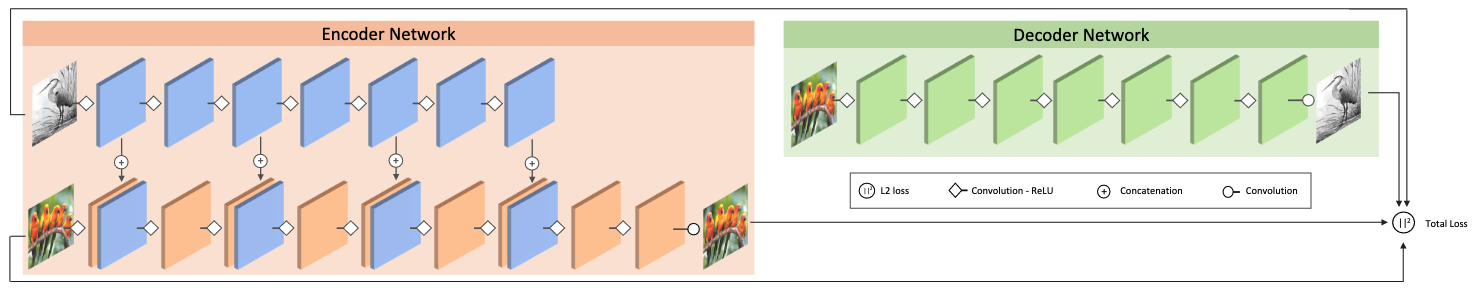

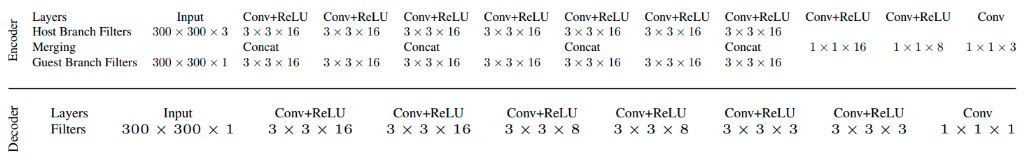

In [ ]:
# imports
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F
from torchvision import datasets, models

class StegNet(nn.Module):
    def __init__(self):
        super(StegNet, self).__init__()
        self.define_encoder()
        self.define_decoder()
        
    def define_encoder(self):
        
        # layer1
        self.encoder_payload_1 = nn.Conv2d(1, SIZE_IMAGE, kernel_size=3, padding=1)
        self.encoder_source_1 = nn.Conv2d(3, SIZE_IMAGE, kernel_size=3, padding=1)
        
        # layer2
        self.encoder_payload_2 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        self.encoder_source_2 = nn.Conv2d(SIZE_IMAGE*2, SIZE_IMAGE*2, kernel_size=3, padding=1)
        self.encoder_source_21 = nn.Conv2d(SIZE_IMAGE*2, SIZE_IMAGE, kernel_size=3, padding=1)
        
        # layer3
        self.encoder_payload_3 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        self.encoder_source_3 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        
        # layer4
        self.encoder_payload_4 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        self.encoder_source_4 = nn.Conv2d(SIZE_IMAGE*4, SIZE_IMAGE*2, kernel_size=3, padding=1)
        self.encoder_source_41 = nn.Conv2d(SIZE_IMAGE*2, SIZE_IMAGE, kernel_size=3, padding=1)
        
        # layer5
        self.encoder_payload_5 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        self.encoder_source_5 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        
        # layer6
        self.encoder_payload_6 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        self.encoder_source_6 = nn.Conv2d(SIZE_IMAGE*6, SIZE_IMAGE*4, kernel_size=3, padding=1)
        self.encoder_source_61 = nn.Conv2d(SIZE_IMAGE*4, SIZE_IMAGE*2, kernel_size=3, padding=1)
        self.encoder_source_62 = nn.Conv2d(SIZE_IMAGE*2, SIZE_IMAGE, kernel_size=3, padding=1)
        
        # layer7
        self.encoder_payload_7 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        self.encoder_source_7 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        
        # layer8
        self.encoder_payload_8 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        self.encoder_source_8 = nn.Conv2d(SIZE_IMAGE*8, SIZE_IMAGE*4, kernel_size=3, padding=1)
        self.encoder_source_81 = nn.Conv2d(SIZE_IMAGE*4, SIZE_IMAGE*2, kernel_size=3, padding=1)
        self.encoder_source_82 = nn.Conv2d(SIZE_IMAGE*2, SIZE_IMAGE, kernel_size=3, padding=1)
        
        # layer9
        self.encoder_source_9 = nn.Conv2d(SIZE_IMAGE, int(SIZE_IMAGE/2), kernel_size=1)
        
        #layer10
        self.encoder_source_10 = nn.Conv2d(int(SIZE_IMAGE/2), int(SIZE_IMAGE/4), kernel_size=1)
        
        #layer11
        self.encoder_source_11 = nn.Conv2d(int(SIZE_IMAGE/4), 3, kernel_size=1)
        
    
    def define_decoder(self):
        
        # layer1
        self.decoder_layers1 = nn.Conv2d(3, SIZE_IMAGE*8, kernel_size=3, padding=1)

        # layer2
        self.decoder_layers2 = nn.Conv2d(SIZE_IMAGE*8, SIZE_IMAGE*4, kernel_size=3, padding=1)

        # layer3
        self.decoder_layers3 = nn.Conv2d(SIZE_IMAGE*4, SIZE_IMAGE*2, kernel_size=3, padding=1)

        # layer4
        self.decoder_layers4 = nn.Conv2d(SIZE_IMAGE*2, SIZE_IMAGE*2, kernel_size=3, padding=1)

        # layer5
        self.decoder_layers5 = nn.Conv2d(SIZE_IMAGE*2, SIZE_IMAGE, kernel_size=3, padding=1)
        
        # payload_decoder
        self.decoder_payload1 = nn.Conv2d(SIZE_IMAGE, int(SIZE_IMAGE/2), kernel_size=3, padding=1)
        self.decoder_payload2 = nn.Conv2d(int(SIZE_IMAGE/2), int(SIZE_IMAGE/2), kernel_size=3, padding=1)
        
        self.decoder_payload3 = nn.Conv2d(int(SIZE_IMAGE/2), int(SIZE_IMAGE/4), kernel_size=3, padding=1)
        self.decoder_payload4 = nn.Conv2d(int(SIZE_IMAGE/4), int(SIZE_IMAGE/4), kernel_size=3, padding=1)
        
        self.decoder_payload5 = nn.Conv2d(int(SIZE_IMAGE/4), 3, kernel_size=3, padding=1)
        self.decoder_payload6 = nn.Conv2d(3, 1, kernel_size=3, padding=1)
        
        
        # source_decoder
        self.decoder_source1 = nn.Conv2d(SIZE_IMAGE, int(SIZE_IMAGE/2), kernel_size=3, padding=1)
        self.decoder_source2 = nn.Conv2d(int(SIZE_IMAGE/2), int(SIZE_IMAGE/2), kernel_size=3, padding=1)
        
        self.decoder_source3 = nn.Conv2d(int(SIZE_IMAGE/2), int(SIZE_IMAGE/4), kernel_size=3, padding=1)
        self.decoder_source4 = nn.Conv2d(int(SIZE_IMAGE/4), int(SIZE_IMAGE/4), kernel_size=3, padding=1)
        
        self.decoder_source5 = nn.Conv2d(int(SIZE_IMAGE/4), 3, kernel_size=3, padding=1)
        self.decoder_source6 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        
    
    def forward(self, x):
        
        source, payload = x
        
        s = source.view((-1, 3, SIZE_IMAGE, SIZE_IMAGE))
        p = payload.view((-1, 1, SIZE_IMAGE, SIZE_IMAGE))
        
        # --------------------------- Encoder -------------------------
        # layer1
        p = F.relu(self.encoder_payload_1(p))
        s = F.relu(self.encoder_source_1(s))
        
        #layer2
        p = F.relu(self.encoder_payload_2(p))
        s1 = torch.cat((s, p), 1)
        s = F.relu(self.encoder_source_2(s1))
        s = F.relu(self.encoder_source_21(s1))
        
        # layer3
        p = F.relu(self.encoder_payload_3(p))
        s = F.relu(self.encoder_source_3(s))
        
        #layer4
        p = F.relu(self.encoder_payload_4(p))
        s2 = torch.cat((s, p, s1), 1)
        s = F.relu(self.encoder_source_4(s2))
        s = F.relu(self.encoder_source_41(s))
        
        # layer5
        p = F.relu(self.encoder_payload_5(p))
        s = F.relu(self.encoder_source_5(s))
        
        #layer6
        p = F.relu(self.encoder_payload_6(p))
        s3 = torch.cat((s, p, s2), 1)
        s = F.relu(self.encoder_source_6(s3))
        s = F.relu(self.encoder_source_61(s))
        s = F.relu(self.encoder_source_62(s))
        
        # layer7
        p = F.relu(self.encoder_payload_7(p))
        s = F.relu(self.encoder_source_7(s))
        
        #layer8
        p = F.relu(self.encoder_payload_8(p))
        s4 = torch.cat((s, p, s3), 1)
        s = F.relu(self.encoder_source_8(s4))
        s = F.relu(self.encoder_source_81(s))
        s = F.relu(self.encoder_source_82(s))
        
        #layer9
        s = F.relu(self.encoder_source_9(s))
        
        #layer10
        s = F.relu(self.encoder_source_10(s))
        
        #layer11
        encoder_output = self.encoder_source_11(s)
        
        # -------------------- Decoder --------------------------
        
        d = encoder_output.view(-1, 3, SIZE_IMAGE, SIZE_IMAGE)
        
        #layer1
        d = F.relu(self.decoder_layers1(d))
        d = F.relu(self.decoder_layers2(d))
        
        #layer3
        d = F.relu(self.decoder_layers3(d))
        d = F.relu(self.decoder_layers4(d))
        
        init_d = F.relu(self.decoder_layers5(d))
        
        # ---------------- decoder_payload ---------------- 

        # layer 1 & 2
        d = F.relu(self.decoder_payload1(init_d))
        d = F.relu(self.decoder_payload2(d))
        # layer 3 & 4
        d = F.relu(self.decoder_payload3(d))
        d = F.relu(self.decoder_payload4(d))
        # layer 5 & 6
        d = F.relu(self.decoder_payload5(d))
        decoded_payload = self.decoder_payload6(d)
        
        # ---------------- decoder_source ---------------- 

        # layer 1 & 2
        d = F.relu(self.decoder_source1(init_d))
        d = F.relu(self.decoder_source2(d))
        # layer 3 & 4
        d = F.relu(self.decoder_source3(d))
        d = F.relu(self.decoder_source4(d))
        # layer 5 & 6
        d = F.relu(self.decoder_source5(d))
        decoded_source = self.decoder_source6(d)
        
        return encoder_output, decoded_payload, decoded_source


    # TODO esto es el ejercicio 3
    def predict_encoder(self, source_image, payload_image):
        
        s = source_image.view((-1, 3, SIZE_IMAGE, SIZE_IMAGE))
        p = payload_image.view((-1, 1, SIZE_IMAGE, SIZE_IMAGE))

        # --------------------------- Encoder -------------------------
        # layer1
        p = F.relu(self.encoder_payload_1(p))
        s = F.relu(self.encoder_source_1(s))
        
        #layer2
        p = F.relu(self.encoder_payload_2(p))
        s1 = torch.cat((s, p), 1)
        s = F.relu(self.encoder_source_2(s1))
        s = F.relu(self.encoder_source_21(s1))
        
        # layer3
        p = F.relu(self.encoder_payload_3(p))
        s = F.relu(self.encoder_source_3(s))
        
        #layer4
        p = F.relu(self.encoder_payload_4(p))
        s2 = torch.cat((s, p, s1), 1)
        s = F.relu(self.encoder_source_4(s2))
        s = F.relu(self.encoder_source_41(s))
        
        # layer5
        p = F.relu(self.encoder_payload_5(p))
        s = F.relu(self.encoder_source_5(s))
        
        #layer6
        p = F.relu(self.encoder_payload_6(p))
        s3 = torch.cat((s, p, s2), 1)
        s = F.relu(self.encoder_source_6(s3))
        s = F.relu(self.encoder_source_61(s))
        s = F.relu(self.encoder_source_62(s))
        
        # layer7
        p = F.relu(self.encoder_payload_7(p))
        s = F.relu(self.encoder_source_7(s))
        
        #layer8
        p = F.relu(self.encoder_payload_8(p))
        s4 = torch.cat((s, p, s3), 1)
        s = F.relu(self.encoder_source_8(s4))
        s = F.relu(self.encoder_source_81(s))
        s = F.relu(self.encoder_source_82(s))
        
        #layer9
        s = F.relu(self.encoder_source_9(s))
        
        #layer10
        s = F.relu(self.encoder_source_10(s))
        
        #layer11
        encoder_output = self.encoder_source_11(s)

        return encoder_output


    # TODO esto es el ejercicio 4
    def predict_decoder(self, encoded_image):
        # -------------------- Decoder --------------------------
        
        d = encoded_image.view(-1, 3, SIZE_IMAGE, SIZE_IMAGE)
        
        #layer1
        d = F.relu(self.decoder_layers1(d))
        d = F.relu(self.decoder_layers2(d))

        #layer3
        d = F.relu(self.decoder_layers3(d))
        d = F.relu(self.decoder_layers4(d))
        
        init_d = F.relu(self.decoder_layers5(d))
        
        # ---------------- decoder_payload ---------------- 

        # layer 1 & 2
        d = F.relu(self.decoder_payload1(init_d))
        d = F.relu(self.decoder_payload2(d))
        # layer 3 & 4
        d = F.relu(self.decoder_payload3(d))
        d = F.relu(self.decoder_payload4(d))
        # layer 5 & 6
        d = F.relu(self.decoder_payload5(d))
        decoded_payload = self.decoder_payload6(d)
        
        # ---------------- decoder_source ---------------- 

        # layer 1 & 2
        d = F.relu(self.decoder_source1(init_d))
        d = F.relu(self.decoder_source2(d))
        # layer 3 & 4
        d = F.relu(self.decoder_source3(d))
        d = F.relu(self.decoder_source4(d))
        # layer 5 & 6
        d = F.relu(self.decoder_source5(d))
        decoded_source = self.decoder_source6(d)
        
        return decoded_payload


### Entrenamiento de la red

#### Demo: explicación y adaptación de parámetros para el entrenamiento del modelo

In [ ]:
# Comprobar si esta disponible ejecutar con GPU y asignarlo de forma automática
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Ejecutando en: {str(device)}')

# Cargamos en memoria la estructura del modelo
model = StegNet()

# Asignamos el modelo a nuestro entorno de ejecución
model.to(device)

#### Definimos la función de pérdida
Para tareas de generación de imágenes es mejor usar la función de pérdida L1 o MAE (Mean Absolute Error) que otras funciones de pérdida como MSE.

https://en.wikipedia.org/wiki/Mean_absolute_error


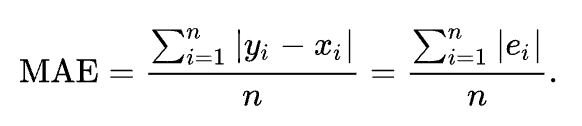

In [ ]:
criterion = nn.L1Loss()
metric = nn.L1Loss()

#### Definimos el optimizador

https://en.wikipedia.org/wiki/Stochastic_gradient_descent

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1) # saber qué cojones es el gamma

#### Código de entrenamiento del modelo

In [ ]:
def get_loss(model, s, p):
    e_out, dp_out, ds_out = model.forward((s, p))
        
    e_loss = criterion(e_out.view((-1, flat_source_size)), s.view((-1, flat_source_size)))
    dp_loss = criterion(dp_out.view((-1, flat_payload_size)), p.view((-1, flat_payload_size)))
    ds_loss = criterion(ds_out.view((-1, flat_source_size)), s.view((-1, flat_source_size)))
    
    loss = e_loss + dp_loss + ds_loss 
    
    return loss

def train_step(model, optimizer, s, p):
    temp_loss = 0.
    optimizer.zero_grad()

    loss = get_loss(model, s, p)

    loss.backward()
    optimizer.step()
    
    temp_loss += loss.item()
    
    return temp_loss

In [ ]:
epochs = 100

train_losses, val_losses = [], []
batch_size = 128
test_batch_size = 100

flat_source_size = SIZE_IMAGE * SIZE_IMAGE * 3
flat_payload_size = SIZE_IMAGE * SIZE_IMAGE
filename_saved = f'{PATH_DRIVE}/solution_model_proof.pt'
valid_loss_min = np.inf # PARA REENTRENAR ÚLTIMO VALIDATION_LOSS

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0.
    total_batches = int(len(source_train) /batch_size) + 1
    for idx in range(total_batches):
        start = idx*batch_size
        end = start + batch_size
        indices1 = np.arange(start, end if end <= len(source_train) else end - (end%len(source_train)))
        indices2 = np.arange(start, end if end <= len(source_train) else end - (end%len(source_train)))
        np.random.shuffle(indices1)
        np.random.shuffle(indices2)
        
        s = source_train[indices1]
        p = payload_train[indices2]
        s, p = torch.from_numpy(s).float().to(device), torch.from_numpy(p).float().to(device)
        train_loss += train_step(model, optimizer, s, p)
    
    else:
        val_loss = 0.
        model.eval()
        val_batches = int(len(source_val) / test_batch_size) 
        with torch.no_grad():
            for idx in range(val_batches):
                s, p = source_val[idx*test_batch_size: (idx * test_batch_size) + test_batch_size], payload_val[idx*test_batch_size: (idx * test_batch_size) + test_batch_size]
                s, p = torch.from_numpy(s).float().to(device), torch.from_numpy(p).float().to(device)
                
                e_out, dp_out, ds_out = model.forward((s, p))

                e_loss = metric(e_out.view((-1, flat_source_size)), s.view((-1, flat_source_size)))
                dp_loss = metric(dp_out.view((-1, flat_payload_size)), p.view((-1, flat_payload_size)))
                ds_loss = metric(ds_out.view((-1, flat_source_size)), s.view((-1, flat_source_size)))
                loss = e_loss + dp_loss + ds_loss
                
                val_loss += loss
            
            train_losses.append(train_loss / (total_batches * 2))
            val_losses.append(val_loss / val_batches)
            
            print('Epoch: {}\nTrain Loss: {}, Val Loss: {}'.format(epoch, train_losses[-1], val_losses[-1]))
        scheduler.step()
        if val_losses[-1] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            val_losses[-1]))
            torch.save(model.state_dict(), filename_saved)
            valid_loss_min = val_losses[-1]

### Explotación de un modelo preentrenado con Pytorch

Cargar modelo preentrenado con Pytorch

In [ ]:
# TODO nosotros: poner el nombre del fichero a cargar definitivo
filename_saved = f'{PATH_DATA}/models/pretrained_model.pt'

def load_model(path_model):
  """
  Metodo para cargar los pesos de un modelo preentrenado
  """
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model = StegNet()
  model.load_state_dict(
    torch.load(path_model, map_location={'cuda:0': 'cpu'}))  # Choose whatever GPU device number you want
  model.to(device)
  return model


model = load_model(filename_saved)
model

In [ ]:
# imports
import skimage
import numpy as np

# Imagenes para visualizar resultados
path_im_source = f'{PATH_DATA}/samples/logo_t3chfest.png' #Cambiar nombre ELEGIR IMAGEN PARA LOS EJERCICIOS
path_im_payload = f'{PATH_DATA}/samples/payload.jpeg' #Cambiar nombre

def image_to_tensor(path_image, convert="RGB", device="cpu"):
    image_array = np.array(open_image_and_resize(path_image, 64, 64).convert(convert)).astype(np.uint8)
    return torch.from_numpy(image_array).float().to(device)


def images_to_tensor(path_source, path_payload, device='cpu'): #todo nosotoros: cambiar método para llamar un open and resize 
    image_source_tensor = image_to_tensor(path_source, convert="RGB", device=device)
    image_payload_tensor = image_to_tensor(path_payload, convert="L", device=device)

    return image_source_tensor, image_payload_tensor


### Ejercicio 3

Realizar predict para esconder una imagen dentro de otra.

In [ ]:
# TODO: añadir método de predict dentro de la definición del modelo

#def predict_encoder(self, source_image, payload_image): #... Se añade en la classe StegNet

In [ ]:
# Función para comprobar resultado del ejercicio
def inference_encoder(path_source, path_payload, device='cpu'):
  im_source, im_payload = images_to_tensor(path_source, path_payload, device=device)
  with torch.no_grad():
    model.eval()
    encoded_image = model.predict_encoder(im_source, im_payload) 
  
  encoded_image = encoded_image.cpu()
  return encoded_image

tensor_result = inference_encoder(path_im_source, path_im_payload, device="cuda")
numpy_tensor_encoded = tensor_result.view((-1, SIZE_IMAGE, SIZE_IMAGE, 3)).numpy()[0]
plt.imshow(numpy_tensor_encoded.astype('uint8'))

In [ ]:
# Guardamos la imagen encodeada en Drive
from skimage.io import imsave, imread

path_im_encoded = f'{PATH_DRIVE}/logo_encoded_result.tif'

imsave(path_im_encoded, numpy_tensor_encoded/255)
image_encoded = imread(path_im_encoded)
assert np.allclose(numpy_tensor_encoded, image_encoded*255) 

### Ejercicio 4

Realizar predict para decodificar el secreto escondido en una imagen dada.

In [ ]:
# TODO: añadir método de predict dentro de la definición del modelo

#def predict_decoder(self, encoded_image): #... Se añade en la classe StegNet

In [ ]:
# Función para comprobar resultado del ejercicio
def inference_decoder(path_image_to_decode, device='cpu'):
  image_to_decode = imread(path_image_to_decode)
  image_to_decode = image_to_decode*255
  image_to_decode_tensor = torch.from_numpy(image_to_decode).float().to(device)

  with torch.no_grad():
      model.eval()
      decoded_payload = model.predict_decoder(image_to_decode_tensor)

  decoded_payload = decoded_payload.cpu()
  decoded_payload_result = decoded_payload.view((-1, SIZE_IMAGE, SIZE_IMAGE)).numpy()[0].astype('uint8') 

  return decoded_payload_result


decoded_image = inference_decoder(path_im_encoded, device="cuda")
plt.imshow(decoded_image, cmap='gray')

## Analizar resultados obtenidos

In [ ]:
%pylab inline
plt.figure(figsize=(5,5))
plt.subplot(2, 3, 1)
plt.title('Encoded Source')
plt.imshow(numpy_tensor_encoded.astype('uint8'))
plt.subplot(2, 3, 2)
plt.title('Decoded Payload')
plt.imshow(decoded_image, cmap='gray')

image_source_numpy = np.array(open_image_and_resize(path_im_source, 64, 64).convert('RGB')).astype(np.uint8)
image_payload_numpy = np.array(open_image_and_resize(path_im_payload, 64, 64).convert('L')).astype(np.uint8)

plt.subplot(2, 3, 4)
plt.title('Original Source')
plt.imshow(image_source_numpy)
plt.subplot(2, 3, 5)
plt.title('Original Payload')
plt.imshow(image_payload_numpy, cmap='gray')

plt.show()

## Demo en directo de productivización resultados